In [1]:
%load_ext autoreload
%autoreload 2

from deep_bf.data_handler import DataLoader
import torch
import numpy as np
from tqdm import tqdm
import os

#urls = "/home/panda/rf_data/dataset/webdataset/dataset-{000..005}.tar"
base_url = "/home/panda/rf_data/dataset/webdataset"

samples_idx_path = "/home/panda/rf_data/dataset/samples_idx"

dl = DataLoader("/home/panda/rf_data/")
df = dl.get_df()

nc = 128
ns = 2300

nz = 2048
nx = 256

seed = 42
batch_size = 1

device = "cuda"
dtype = torch.float32

In [2]:
from deep_bf.dataset import get_datasets

train, val = get_datasets(base_url, seed, batch_size)
it = iter(train)

In [3]:
i = 34
for _ in range(i):
    sample = next(it)

In [4]:
rfs, ids, gt, name = sample
gt = gt.squeeze()
name = name[0]

print(rfs.shape, gt.shape, name)


torch.Size([1, 1, 128, 2300]) torch.Size([2048, 256]) TSH132


In [3]:
import torch
from tqdm import tqdm

def _has_nan(x: torch.Tensor) -> bool:
    return torch.isnan(x).any().item()

def scan_loaders_for_nan(train_loader, val_loader, device="cpu", check_keys=("rf", "gt")):
    loaders = [("train", train_loader), ("val", val_loader)]
    results = {}

    for split_name, loader in loaders:
        rf_nan = 0
        gt_nan = 0
        total = 0
        first_rf_key = None
        first_gt_key = None

        pbar = tqdm(loader, desc=f"Scanning {split_name}", leave=False)
        for sample in pbar:
            if isinstance(sample, (list, tuple)) and len(sample) >= 4:
                rfs, _, gts, keys = sample[0], sample[1], sample[2], sample[3]
            elif isinstance(sample, dict):
                rfs = sample.get("rf") or sample.get("rf.npy")
                gts = sample.get("gt") or sample.get("gt.npy")
                keys = sample.get("__key__", None)
            else:
                raise TypeError(f"Unsupported sample type for {split_name}: {type(sample)}")

            if device is not None:
                rfs = rfs.to(device, non_blocking=True)
                gts = gts.to(device, non_blocking=True)

            if _has_nan(rfs):
                rf_nan += 1
                if first_rf_key is None:
                    first_rf_key = keys

            if _has_nan(gts):
                gt_nan += 1
                if first_gt_key is None:
                    first_gt_key = keys

            total += 1
            pbar.set_postfix(total=total, rf_nan=rf_nan, gt_nan=gt_nan)

        results[split_name] = {
            "total_batches": total,
            "batches_with_rf_nan": rf_nan,
            "batches_with_gt_nan": gt_nan,
            "first_key_with_rf_nan": first_rf_key,
            "first_key_with_gt_nan": first_gt_key,
        }

    return results

# Example:
results = scan_loaders_for_nan(train, val, device="cpu")
print(results)

Scanning train: 0it [00:00, ?it/s]

{'train': {'total_batches': 485, 'batches_with_rf_nan': 0, 'batches_with_gt_nan': 0, 'first_key_with_rf_nan': None, 'first_key_with_gt_nan': None}, 'val': {'total_batches': 54, 'batches_with_rf_nan': 0, 'batches_with_gt_nan': 0, 'first_key_with_rf_nan': None, 'first_key_with_gt_nan': None}}


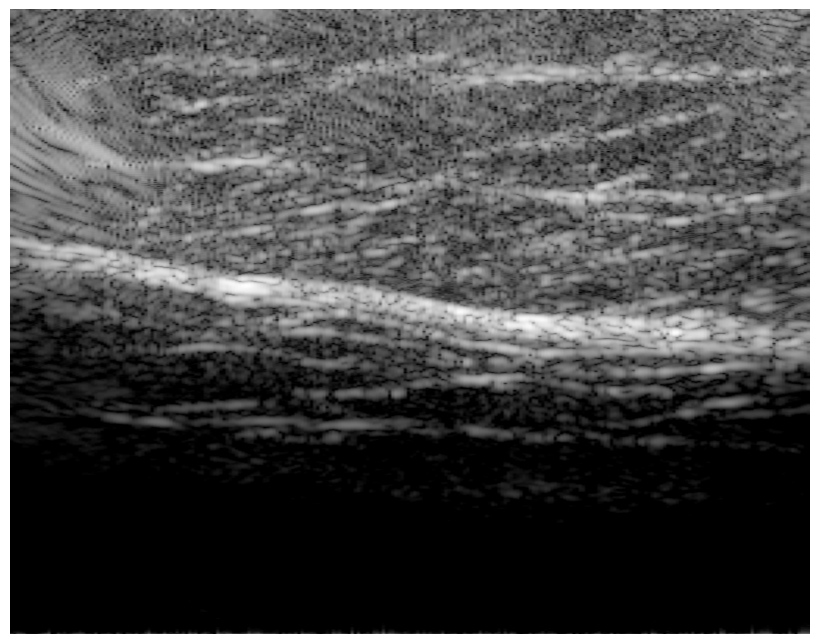

In [5]:
import matplotlib.pyplot as plt
from deep_bf.beamformers import compute_meshgrid, get_rf_bmode

# TODO: Sacar el zlims, xlims con el samples_idx

pw = dl.get_defined_pwdata(name, "RF")
Z, X = compute_meshgrid(pw, nz, nx)

Z = Z.cpu()
X = X.cpu()

zlims = np.array([Z[0, 0], Z[-1, 0]]) * 1e3
xlims = np.array([X[0, 0], X[0, -1]]) * 1e3

vmin = -60
vmax = 0

fig = plt.figure(figsize=(8, 10), frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

b_mode = get_rf_bmode(gt, vmin, vmax)
extent = (xlims[0], xlims[-1], zlims[-1], zlims[0])

ax.imshow(b_mode, cmap='gray', vmin=vmin, vmax=vmax,
          extent=extent,
          aspect='equal')
ax.set_axis_off()
plt.show()

In [7]:
import h5py
import hdf5plugin
from pathlib import Path

path_a = Path("/home/panda/rf_data/dataset/raw")
path_b = Path("/home/panda/rf_data/dl_data")

filename = "TSH014"

pa = path_a / f"{filename}.hdf5"
pb = path_b / f"{filename}.hdf5"

with h5py.File(pa, "r") as fa:
    print(list(fa.keys()))
    rfa = fa["rf"][:]
    gta = fa["ground_truth"][:]
    print(rfa.shape, gta.shape)

with h5py.File(pb, "r") as fb:
    print(list(fb.keys()))
    rfb = fb["rfdata"][:]
    gtb = fb["img"][:]
    print(rfb.shape, gtb.shape)

['ground_truth', 'rf']
(128, 2800) (2048, 256)
['grid', 'img', 'probe_geometry', 'rfdata']
(128, 2800) (2048, 256)


In [11]:
import numpy as np

def compare(a, b):
    print(np.array_equal(a, b))

    diff_mask = (a != b)
    n_diff = diff_mask.sum()
    print(f"Number of differing elements: {n_diff/a.size}")

    print(np.allclose(a, b, rtol=1e-5, equal_nan=True))

    close_mask = np.isclose(a, b, rtol=1e-5, atol=1e-8, equal_nan=True)
    print(close_mask.mean())

    abs_diff = np.abs(a - b)
    max_abs = abs_diff.max()
    mean_abs = abs_diff.mean()
    rmse = np.sqrt(np.mean((a - b)**2))

    print(max_abs, mean_abs, rmse)

    den = np.maximum(np.abs(a), 1e-12)
    rel_diff = abs_diff / den
    max_rel = rel_diff.max()
    mean_rel = rel_diff.mean()

    print(max_rel, mean_rel)

In [12]:
compare(rfa, rfb)

False
Number of differing elements: 0.7121484375
False
0.2878515625
16361.735 220.70314 730.739
0.9986411 0.7111807


In [13]:
compare(gta, gtb)

False
Number of differing elements: 1.0
False
0.0
1786.6487 11.374075 33.895573
148.66884 1.0006398


In [6]:
import pandas as pd

path = "./deep_bf/data_handler/data/data.csv"

df = pd.read_csv(path)

new_names = {
    "sampling_frecuency": "fs",
    "center_frecuency": "fc",
    "n_samples": "ns",
    "n_channels": "nc",
    "n_angles": "na",
}

new_order = [
    "name", "na", "nc", "ns", "fs", "fc", "pitch", 
    "element_width", "aperture_width", "zlims", "angles_range", 
    "RF", "IQ", "type", "source", "set", "path"
]

df = df.rename(columns=new_names)
df = df[new_order]

df.to_csv(path, index=False)


print(df.head())

     name  na   nc    ns     fs    fc  pitch  element_width  aperture_width  \
0  MYO001  75  128  2688  28.96  6.25    0.3           0.27            38.4   
1  MYO002  75  128  2688  28.96  6.25    0.3           0.27            38.4   
2  MYO003  75  128  2688  28.96  6.25    0.3           0.27            38.4   
3  MYO004  75  128  2688  28.96  6.25    0.3           0.27            38.4   
4  MYO005  75  128  2688  28.96  6.25    0.3           0.27            38.4   

           zlims angles_range  RF  IQ     type source                set  \
0  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   
1  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   
2  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   
3  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   
4  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   

                                                path  
0  /mnt/g/mem

In [ ]:
import pandas as pd

path = "./deep_bf/data_handler/data/data.csv"

df = pd.read_csv(path)

new_value = "[10e-3, 40e-3]" # [10e-3, 45e-3]

df.loc[df['name'].str.startswith("TSH"), 'zlims'] = new_value


df.to_csv(path, index=False)

#df = df.query("name == 'TSH003'")
print(df.head())

     name  na   nc    ns     fs    fc  pitch  element_width  aperture_width  \
0  MYO001  75  128  2688  28.96  6.25    0.3           0.27            38.4   
1  MYO002  75  128  2688  28.96  6.25    0.3           0.27            38.4   
2  MYO003  75  128  2688  28.96  6.25    0.3           0.27            38.4   
3  MYO004  75  128  2688  28.96  6.25    0.3           0.27            38.4   
4  MYO005  75  128  2688  28.96  6.25    0.3           0.27            38.4   

           zlims angles_range  RF  IQ     type source                set  \
0  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   
1  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   
2  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   
3  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   
4  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   

                                                path  
0  /mnt/g/mem

In [2]:
import pandas as pd

path = "./deep_bf/data_handler/data/data.csv"

df = pd.read_csv(path)

new_value = "[20e-3, 50e-3]" # [10e-3, 35e-3]

df.loc[df['name'].str.startswith("UFL"), 'zlims'] = new_value


df.to_csv(path, index=False)

#df = df.query("name == 'TSH003'")
print(df.head())

     name  na   nc    ns     fs    fc  pitch  element_width  aperture_width  \
0  MYO001  75  128  2688  28.96  6.25    0.3           0.27            38.4   
1  MYO002  75  128  2688  28.96  6.25    0.3           0.27            38.4   
2  MYO003  75  128  2688  28.96  6.25    0.3           0.27            38.4   
3  MYO004  75  128  2688  28.96  6.25    0.3           0.27            38.4   
4  MYO005  75  128  2688  28.96  6.25    0.3           0.27            38.4   

           zlims angles_range  RF  IQ     type source                set  \
0  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   
1  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   
2  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   
3  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   
4  [5e-3, 55e-3]    [-16, 16]   1   1  phantom  CUBDL  CUBDL Task 1 Data   

                                                path  
0  /mnt/g/mem

In [ ]:
git commit -m "feat: train loop and quick setup for global variables"